## E-commerce Data Analysis

In [58]:
import numpy as np
import pandas as pd
from scipy import stats # if needed for outliers
import regex
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data/data.csv", delimiter=',', encoding='unicode_escape')
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [3]:
data.isna().sum() # 1454 missing in Description - they can be filled by finding the stockcode corresponding 
                # customer ID has ALOT more missing values - easier to drop it 
data[data["Description"].isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


Create a dictionary with highest number of description for each stockcode. Map the dictionary to fill empty in description

In [4]:
# find most frequent description to every stockcode
most_frequent_description = data.groupby(by=["StockCode"])["Description"].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
description_map = most_frequent_description.to_dict()
data["Description"] = data["Description"].fillna(data['StockCode'].map(description_map))


From 1454 missing in description to only 112. 
Drop the missing values left for description and customerID

In [7]:
data.dropna(subset=["Description"], inplace=True)
data.drop('CustomerID', axis=1, inplace=True)

Check duplicated values

In [8]:
data.drop_duplicates(inplace=True)

In [9]:
# check the number of users and products 
number_transactions = len(data["InvoiceNo"].value_counts())
number_products = len(data["StockCode"].value_counts())
number_countries = len(data["Country"].value_counts())
invoice_no = list(data["InvoiceNo"].values)
canceled = [invoice for invoice in invoice_no if invoice.startswith('C')]
data_quantity = pd.DataFrame({'Total Transactions': number_transactions, 'Cancelled Transactions': len(canceled), 'Products': number_products, "Countries": number_countries}, index=['quantity'])
data_quantity


,Total Transactions,Cancelled Transactions,Products,Countries
quantity,25788,9251,3958,38


In [12]:
data_to_cluster = data[["InvoiceNo", "StockCode", "Country"]]
data_to_cluster["TotalAmount"] = data.loc[:,"Quantity"] * data.loc[:,"UnitPrice"]

C:\Users\batou\AppData\Local\Temp\ipykernel_6720\1844502594.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_to_cluster["TotalAmount"] = data.loc[:,"Quantity"] * data.loc[:,"UnitPrice"]


### Categorical Encoding
*Binary Encode* the StockCode:

    - Binary encode leverage label encoding and one-hot encoding especially for large amount of data

*Label Encode* Countries

*Customer Encode* invoice number that corresponds to cancelled transactions to 0

In [14]:
# Binary encode the stockcode
import category_encoders as ce

c_e = ce.BinaryEncoder()
df_fit = c_e.fit_transform(data_to_cluster["StockCode"])

Analyze the number of different categories for InvoiceNo

In [20]:
# find the values that start with string
pattern = r'^[A-BD-Z]'
mask = data_to_cluster['InvoiceNo'].astype(str).str.match(pattern)
data_to_cluster = data_to_cluster[~mask]
# only 3 counts of values that start with A it is better to remove as Kmeans prefers clusters of equal volumes

In [ ]:
data_to_cluster.loc[:,"InvoiceNo"] = data_to_cluster["InvoiceNo"].apply(lambda x: 0 if x.startswith('C') else x)

Join the encoded StockCode and drop the categorical

In [28]:
total_df = data_to_cluster.join(df_fit)
total_df.drop("StockCode", axis=1,inplace=True)

In [29]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder()
total_df["Country"] = le.fit_transform(total_df["Country"])

Split the data, then scale the data with StandardScalar()

In [30]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(total_df, test_size=0.2, random_state=np.random.seed(42))

In [32]:
from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
data_train_scaled = scalar.fit_transform(data_train)
data_test_scaled = scalar.transform(data_test)

In [43]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
data_train_pca = pca.fit_transform(data_train_scaled)
data_test_pca = pca.transform(data_test_scaled) # only removed one feature and made score better

(429220, 14)

Instead of .predict that performs *hard clustering*, .transform that gives *soft clustering* by providing each point's distance from the each cluster and then we can take the smallest distance.

### Optimize the algorithm by using Elbow method

In [62]:
# improve K by using elbow method 
# model.inertia for every rep with different k plot and see the best
# another better score would be the silhoutee for every trial but each trail is taking too long to run

inertias = []
k_range = range(1,20)
for i in k_range:
    kmeans = KMeans(n_clusters=i, random_state=np.random.seed(43))
    kmeans.fit(data_train_pca)
    # get the inertia which tells the sum squared distances 
    inertias.append(kmeans.inertia_)


c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\clus

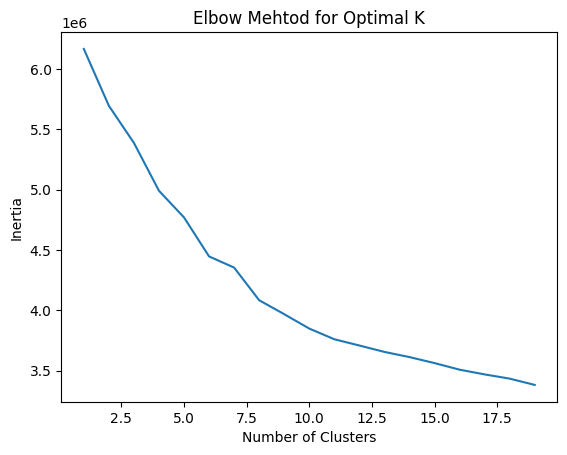

In [63]:
# plot it for visualization

plt.plot(k_range, inertias)
plt.title("Elbow Mehtod for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [66]:
model = KMeans(n_clusters=11, random_state=np.random.seed(43))
model.fit(data_train_pca)

c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=11)

In [67]:
train_clusters = model.predict(data_train_pca)
test_clusters = model.predict(data_test_pca)
model.score(data_train_pca) # high inertia meaning the distance is large so not best
#model.labels_.shape # 429220 labels 
#model.cluster_centers_

-3760158.8890510104

Background on silhouette score:

The score is used to evaluate the quality of the clustering results. This is done by quantifying how well each data point lies within its cluster concidering how close the data points in the same cluster are (cohesion) and how far away the data points in different clusters are from each other (seperation).

The score ranges from -1 to +1. 

    +1 indicates that the point is far away from the neighbouring cluster and very close to the point in its own cluster (well clustered).

    0 indicates the point is close to the decision boundary between two neighbouring clusters.

    -1 indicates that the point might have been assigned to the wrong cluster.

The overall silhouette score for a clustering solution is the average silhouette coefficient over all data points.


In [68]:
train_score = silhouette_score(data_train_pca, train_clusters)
test_score = silhouette_score(data_test_pca, test_clusters)

print(f'Train Silhouette Score: {train_score}') # 0.103
print(f'Test Silhouette Score: {test_score}') # 0.102

Train Silhouette Score: 0.1027430931410784
Test Silhouette Score: 0.1017802165818907


### MiniBatch K-Means

Helps speed up the algorithm by factor of 3 or 4 and makes it possible to cluster huge datasets that do not fit in memory. (Ref: Hands-on machine learning with Scikit-Learning)

In [69]:
from sklearn.cluster import MiniBatchKMeans

# should also iterate for the best n_clusters

minibatch_k_range = range(1,20)
batch_size = 10000
minibatch_interia = []

for i in minibatch_k_range:
    minibatch_kmeans = MiniBatchKMeans(n_clusters=i, random_state=np.random.seed(43), batch_size=batch_size)
    minibatch_kmeans.fit(data_train_pca)
    minibatch_interia.append(minibatch_kmeans.inertia_)
    

c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)
c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_k

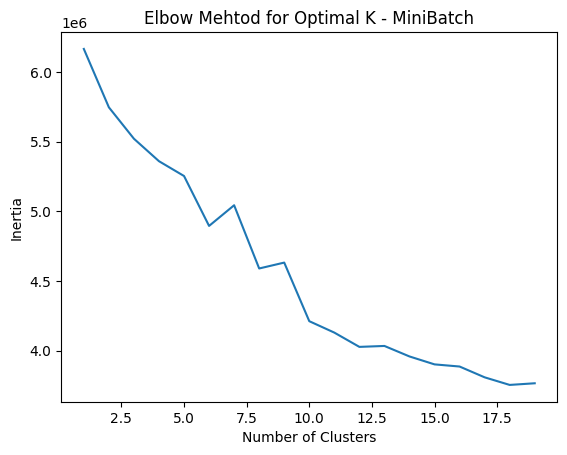

In [70]:

plt.plot(minibatch_k_range, minibatch_interia)
plt.title("Elbow Mehtod for Optimal K - MiniBatch")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

In [71]:
minibatch_model = MiniBatchKMeans(n_clusters=11, random_state=np.random.seed(43), batch_size=batch_size)
minibatch_model.fit(data_train_pca)
train_mini_clusters = minibatch_model.predict(data_train_pca)
test_mini_clusters = minibatch_model.predict(data_test_pca)



c:\Users\batou\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [ ]:
train_score = silhouette_score(data_train_pca, train_mini_clusters) #0.078 not better
test_score = silhouette_score(data_test_pca, test_mini_clusters)

print(f'Train Silhouette Score: {train_score}') # 
print(f'Test Silhouette Score: {test_score}') # 

## Alternate Clustering Algorithm

In [75]:
data.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'Country'],
      dtype='object')

In [76]:
data["InvoiceDate"]

0          12/1/2010 8:26
1          12/1/2010 8:26
2          12/1/2010 8:26
3          12/1/2010 8:26
4          12/1/2010 8:26
               ...       
541904    12/9/2011 12:50
541905    12/9/2011 12:50
541906    12/9/2011 12:50
541907    12/9/2011 12:50
541908    12/9/2011 12:50
Name: InvoiceDate, Length: 536529, dtype: object